In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import sklearn.linear_model
import os.path

import time

from NeuralNet import NeuralNet
from utils.json import *
from utils.nnsetup import *
from utils.attackperformance import *

np.random.seed(1)

In [2]:
X_train, Y_train, Y_train_e, X_test, Y_test = get_datasets()

In [ ]:
cls = NeuralNet(layer_dims = [784, 60, 10], learning_rate = 0.1, num_iter = 300,
                normalize = False, mini_batch_size=2048)

cls = getNN("nets/main_nn_300")

In [ ]:
Y_train_hat = cls.predict(X_train)
Y_test_hat = cls.predict(X_test)

print(accuracy_score(Y_train, Y_train_hat))
print(accuracy_score(Y_test, Y_test_hat))

## Pixel DP defense

In [3]:
cls_dp = NeuralNet(layer_dims = [784, 60, 10], learning_rate = 0.1, num_iter = 300,
                     normalize = False, mini_batch_size=2048,
                     noise_layer=1, noise_layer_sensitivity=1, noise_type='Laplacian',
                     attack_size=1, eps=1)

In [ ]:
cls_dp.fit(X_train, Y_train)

In [4]:
cls_dp = getNN("nets/main_nn_300")
cls_dp.noise_layer = 1
cls_dp.noise_layer_sensitivity = 1
cls_dp.noise_type = 'Laplacian'
cls_dp.attack_size = 1
cls_dp.eps=2

In [5]:
cls_dp.num_iter

100

In [6]:
Y_train_hat = cls_dp.predict(X_train)
Y_test_hat = cls_dp.predict(X_test)

print(accuracy_score(Y_train, Y_train_hat))
print(accuracy_score(Y_test, Y_test_hat))

0.604672619047619
0.6014285714285714


In [17]:
cls_dp.n_expected_scores = 20

In [18]:
n = 1000

Y_train_hat = cls_dp.predict(X_train[:n].copy())
Y_test_hat = cls_dp.predict(X_test[:n].copy())

print(accuracy_score(Y_train[:n], Y_train_hat))
print(accuracy_score(Y_test[:n], Y_test_hat))

0.921
0.917


## Attact test

In [19]:
X_test_c = X_test[:100].copy()
Y_test_c = Y_test[:100].copy()

In [20]:
test_epsilon = [1/255]
#test_epsilon = [1/255, 3/255, 5/255, 10/255, 15/255, 30/255, 50/255, 80/255, 120/255]
ignore_not_adversarial = False

In [21]:
df, insights_dp, initial_dp, adversarial_dp = get_insights(cls_dp, test_epsilon, X_test_c, Y_test_c,
                                                  ignore_not_adversarial=ignore_not_adversarial)
df

epsilon = 0.00392156862745098
10 instances, 2 adversaries
20 instances, 3 adversaries
30 instances, 5 adversaries
40 instances, 6 adversaries
50 instances, 8 adversaries
60 instances, 8 adversaries
70 instances, 9 adversaries
80 instances, 9 adversaries
90 instances, 9 adversaries
100 instances, 9 adversaries
100 instances, 9 adversaries
------------------------------
total time: 2.424128532409668
total iter: 193


,target,successful attempts,epsilon
0,NaN,9.0,0.003922


In [28]:
insights_dp

,original,prediction,iterations,epsilon,L2 norm
0,7.0,7.0,0.0,0.003922,0.000000
1,3.0,3.0,18.0,0.003922,0.992110
2,9.0,4.0,2.0,0.003922,0.136525
3,8.0,8.0,2.0,0.003922,0.142693
4,6.0,6.0,0.0,0.003922,0.000000
...,...,...,...,...,...
95,4.0,4.0,0.0,0.003922,0.000000
96,6.0,6.0,6.0,0.003922,0.430498
97,5.0,5.0,0.0,0.003922,0.000000
98,5.0,5.0,4.0,0.003922,0.280961


In [26]:
cls_dp.predict(adversarial_dp)

array([4, 9, 1, 2, 3, 6, 7, 3, 4], dtype=int64)

In [27]:
cls_dp.predict(initial_dp)

array([9, 4, 8, 3, 2, 6, 7, 1, 4], dtype=int64)

In [22]:
n_iter = max(insights_dp['iterations'])
iterations = np.arange(n_iter)
n_iter

18.0

In [23]:
#accuracy = []
accuracy_dp = []
for i in iterations:
  #accuracy.append(1 - sum(insights['iterations']<=i)/insights.shape[0])
  accuracy_dp.append(1 - sum(insights_dp['iterations']<=i)/insights_dp.shape[0])

In [24]:
#distance = []
distance_dp = []
ticks = np.linspace(np.min(insights_dp['L2 norm']), np.max(insights_dp['L2 norm']), 100)
for i in ticks:
  #distance.append(1 - sum(insights['L2 norm']<=i)/insights.shape[0])
  distance_dp.append(1 - sum(insights_dp['L2 norm']<=i)/insights_dp.shape[0])

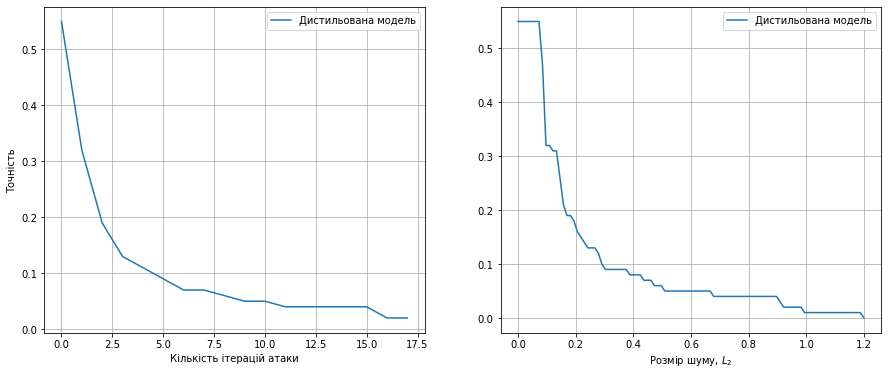

In [25]:
def set_axis(ax):
  ax.set_axisbelow(True)
  ax.grid()
  ax.legend()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))

#ax1.plot(iterations, accuracy, label='Прообраз')
ax1.plot(iterations, accuracy_dp, label='Дистильована модель')
ax1.set_xlabel('Кількість ітерацій атаки')
ax1.set_ylabel('Точність')
set_axis(ax1)

#ax2.plot(ticks, distance, label='Прообраз')
ax2.plot(ticks, distance_dp, label='Дистильована модель')
ax2.set_xlabel('Розмір шуму, $L_2$')
set_axis(ax2)

plt.savefig("images/distAllT.pdf", bbox_inches = 'tight', pad_inches = 0)

In [ ]:
#save_to_json(cls_dist.parameters, "nets/pixeldp_nn_300"+str(T))